In [3]:
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
from glob import glob
from datetime import datetime
from tqdm import tqdm
from xhistogram.xarray import histogram
from scipy.ndimage import gaussian_filter

In [4]:
import dask
from dask.distributed import Client, LocalCluster
cluster = LocalCluster(n_workers = 20, dashboard_address=':4242') #number of cores
client = Client(cluster) # go check dask dashboard

In [5]:
dt0 = datetime(2022,10,24)

dscatt = xr.open_dataset(f"../../data/processed/dopplerscatt_moses/dopplerscatt_{dt0.strftime('%Y%m%d')}.nc")
moses = xr.open_dataset(f"../../data/processed/dopplerscatt_moses/moses_{dt0.strftime('%Y%m%d')}_binned.nc")

for dim in ["x", "y"]:
    ref = moses[f"{dim}_bin"].where(np.isnan(moses.SST)).mean()
    dscatt[f"{dim}"] = (dscatt[f"{dim}"] - ref) * 1e-3
    moses[f"{dim}_bin"] = (moses[f"{dim}_bin"] - ref) * 1e-3

In [6]:
Lx, Ly = 43, 15
windm = dscatt.sel(x = slice(-Lx, Lx), y = slice(-7, 15)).wind_speed_all_lines.mean()

In [7]:
ds = dscatt.copy()
for var in ["u_current_all_lines", "v_current_all_lines"]:
    ds[var] = ds[var] - dscatt[f"mean_{var}"]
    
ds["current_speed"] = (dscatt["current_speed"]*10).round()/10
ds = ds.sel(x = slice(-Lx, Lx), y = slice(-7, 15))

subset = lambda ds: ds.isel(x = slice(None,None,20), y = slice(None,None,20))

In [8]:
kw = dict(
    sst = dict(
        x = "x_bin", y = "y_bin",
        vmin = 16.5, vmax = 19.5,
        levels = np.arange(16.5, 19.6, 0.1),
        cmap = "Spectral_r", extend = "both",
        cbar_kwargs = dict(label = "SST [$^\circ$C]", fraction = 0.01,
                           ticks = np.arange(16.5, 19.6, 0.5))
    ),
    streamlines = dict(
        x = "x", y = "y",
        u = "u_current_all_lines", v = "v_current_all_lines",
        cmap = ListedColormap(["0.8", "0.5", "0.3", "0.08"]), add_guide = False,
        hue = "current_speed", density = 2, linewidth = 0.5, vmin = 0.1, vmax = 0.9,
    ),
    vorticity = dict(
        x = "x", y = "y", vmin = -2, vmax = 2, cmap = "RdBu_r",
        cbar_kwargs = dict(label = "$\zeta/f$", fraction = 0.01)
    ),
    quiver = dict(x = "x", y = "y", u = "wind_u", v = "wind_v",
                  scale = 150, alpha = 0.8, add_guide = False),
    windspeed = dict(
        x = "x", y = "y",
        vmin = windm-2.5, vmax = windm+2.5,
        cmap = "PiYG_r",
        cbar_kwargs = dict(label = "Wind speed [m$\,$s$^{-1}$", fraction = 0.01))
)


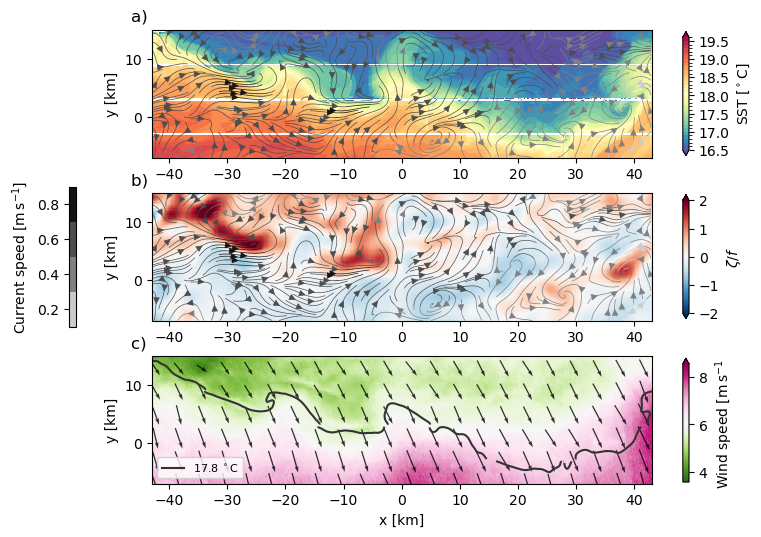

In [10]:
fig, ax = plt.subplots(3,1, figsize = (8, 6))

moses.SST.plot(**kw["sst"], ax = ax[0])

dscatt.Ro.plot(**kw["vorticity"], ax = ax[1])

for a in ax[:2]:
    c = ds.plot.streamplot(ax = a, **kw["streamlines"])

dscatt.wind_speed_all_lines.plot(ax = ax[2], **kw["windspeed"])
moses.mean_SST.plot.contour(ax = ax[2], x = "x_bin", y = "y_bin",
                        levels = [17.8], colors = ["0.2"])
ax[2].plot([], [], "0.2", label = "17.8 $^\circ$C")
ax[2].legend(loc = 3, fontsize = 8)
subset(dscatt).plot.quiver(ax = ax[2], **kw["quiver"])

for a in ax:
    a.axis("scaled")
    a.set(
        xlim = [-Lx, Lx],
        ylim = [-7, 15],
        xlabel = "x [km]",
        ylabel = "y [km]"
    )
[a.set(xlabel = "") for a in ax[:-1]]

for a, letter in zip(ax, ["a)", "b)", "c)"]):
    a.set_title(f"{letter}" + 100*" ")

fig.colorbar(c, ax = ax, location = "left", pad = 0.13,
             fraction = 0.012, label = "Current speed [m$\,$s$^{-1}$]")

fig.savefig(f"../../img/dopplerscatt_moses_{dt0.strftime('%Y%m%d')}.png",
            dpi = 300, bbox_inches = "tight", facecolor = "w")